# Memory Agent

## Review

We created a chatbot that saves semantic memories to a single [user profile](https://langchain-ai.github.io/langgraph/concepts/memory/#profile) or [collection](https://langchain-ai.github.io/langgraph/concepts/memory/#collection).

We introduced [Trustcall](https://github.com/hinthornw/trustcall) as a way to update either schema.

## Goals

Now, we're going to turn our chatbot into a simple [agent](https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/).

The chatbot *always* reflected on the conversation and saved memories. 

The central difference is that the agent will decide *when* to save memories. 

For this, we're going to introduce a tool that allows the agent to save memories. 

%%capture --no-stderr
%pip install -U langchain_openai langgraph

In [1]:
import os, getpass

def _set_env(var: str):
    # Check if the variable is set in the OS environment
    env_value = os.environ.get(var)
    if not env_value:
        # If not set, prompt the user for input
        env_value = getpass.getpass(f"{var}: ")
    
    # Set the environment variable for the current process
    os.environ[var] = env_value

_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

## Adding a router

There are many different [agent](https://langchain-ai.github.io/langgraph/concepts/high_level/) architectures to choose from.

Here, we'll implement something simple: a router that decides when to save memories.

This will reflect on the chat history and any prior memories to decide whether to update the memory collection.

The updating itself will be handled by `Trustcall`, as before!


In [2]:
# Memory schema
from pydantic import BaseModel, Field

# Schema for binary decision to save memories
class SaveMemory(BaseModel):
    """ Profile of a user """
    store_memories: bool = Field(description="Decision to save memories based on the conversation with the user.")

LangChain's chat model [chat model](https://python.langchain.com/docs/concepts/chat_models/) interface has a [`with_structured_output`](https://python.langchain.com/docs/concepts/structured_outputs/#recommended-usage) method to enforce structured output.

As we showed before, this is useful when we want to enforce that the output conforms to a schema, and it parses the output for us.

In [4]:
_set_env("OPENAI_API_KEY")

In [3]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_openai import ChatOpenAI

# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Bind the schema to the model
model_with_structure = model.with_structured_output(SaveMemory)

# Current memory collection
info = "This user's name is Lance and he likes to bike."

# System message
system_msg = f"""You manage are deciding whether to update the memory collection for the user.
    Here is the current memory collection (it may be empty): <memories>{info}</memories>
    Here is the chat history. Assess whether the chat history contains any information that should be added to the memory collection."""

# Invoke with new information
store_memories_flag = model_with_structure.invoke([SystemMessage(content=system_msg)]+[HumanMessage(content="I like to eat croissants")])
store_memories_flag.store_memories

True

## Graph definition 

We add a simple router, `route_message`, that makes a binary decision to save memories.

The memory collection updating is handled by `Trustcall` in the `write_memory` node, as before!

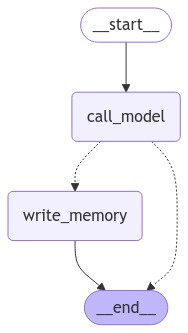

In [6]:
import uuid
from IPython.display import Image, display

from datetime import datetime
from dataclasses import dataclass

from trustcall import create_extractor

from typing_extensions import Annotated

from langchain_core.runnables import RunnableConfig
from langchain_core.messages import ToolMessage, AnyMessage
from langchain_core.messages import merge_message_runs

from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.store.memory import InMemoryStore
from langgraph.store.base import BaseStore
    
# Initialize the model
model = ChatOpenAI(model="gpt-4o", temperature=0)

# Schema 
class Memory(BaseModel):
    content: str = Field(description="The main content of the memory. For example: User expressed interest in learning about French.")
    context: str = Field(description="Additional context for the memory. For example: This was mentioned while discussing career options in Europe.")

# Create the Trustcall extractor
trustcall_extractor = create_extractor(
    model,
    tools=[Memory],
    tool_choice="Memory",
    # This allows the extractor to insert new memories
    enable_inserts=True,
)

# Node definitions
def call_model(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Load memories from the store and use them to personalize the chatbot's response."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"[{mem.key}]: {mem.value}" for mem in memories)
    system_msg = f"""You are a helpful assistant with memory that provides information about the user.  
    If you have memory for this user, use it to personalize your responses.
    Here is the memory (it may be empty): {info}"""

    # Respond using memory as well as the chat history
    response = model.invoke([SystemMessage(content=system_msg)]+state["messages"])

    return {"messages": [response]}

def write_memory(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the chat history and update the memory collection."""
    
    # Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Define the namespace for the memories
    namespace = ("memories", user_id)

    # Retrieve the most recent memories for context
    existing_items = store.search(namespace)

    # Format the existing memories for the Trustcall extractor
    tool_name = "Memory"
    existing_memories = ([(existing_item.key, tool_name, existing_item.value)
                          for existing_item in existing_items]
                          if existing_items
                          else None
                        )

    # Format the chat history for the Trustcall extractor
    system_msg = """Reflect on following interaction. Use the provided tools to retain any necessary memories about the user. 
    Use parallel tool calling to handle updates & insertions simultaneously:"""
    updated_messages=list(merge_message_runs(messages=[SystemMessage(content=system_msg)] + state["messages"]))

    # Invoke the extractor
    result = trustcall_extractor.invoke({"messages": updated_messages, 
                                        "existing": existing_memories})

    # Save save the memories from Trustcall to the store
    for r, rmeta in zip(result["responses"], result["response_metadata"]):
        store.put(namespace,
                  rmeta.get("json_doc_id", str(uuid.uuid4())),
                  r.model_dump(mode="json"),
            )

# Conditional edge
def route_message(state: MessagesState, config: RunnableConfig, store: BaseStore):

    """Reflect on the memories and chat history to decide whether to update the memory collection."""

    # Get the user ID from the config# Get the user ID from the config
    user_id = config["configurable"]["user_id"]

    # Retrieve memory from the store
    namespace = ("memories", user_id)
    memories = store.search(namespace)

    # Format the memories for the system prompt
    info = "\n".join(f"[{mem.key}]: {mem.value}" for mem in memories)

    # Consider whether to save memories
    model_with_structure = model.with_structured_output(SaveMemory)
    system_msg = f"""You manage are deciding whether to update the memory collection for the user.
    Here is the current memory collection (it may be empty): <memories>{info}</memories>
    Here is the chat history. Assess whether the chat history contains any information that should be added to the memory collection."""
    store_memories_flag = model_with_structure.invoke([SystemMessage(content=system_msg)]+state["messages"])

    # Check if model has chosen to store memories
    if store_memories_flag.store_memories:
        return "write_memory"
    
    # Otherwise, finish; user can send the next message
    return END

# Create the graph + all nodes
builder = StateGraph(MessagesState)

# Define the flow of the memory extraction process
builder.add_node(call_model)
builder.add_edge("__start__", "call_model")
builder.add_node(write_memory)
builder.add_conditional_edges("call_model", route_message, ["write_memory", END])
builder.add_edge("write_memory", END)

# Store for long-term (across-thread) memory
across_thread_memory = InMemoryStore()

# Checkpointer for short-term (within-thread) memory
within_thread_memory = MemorySaver()

# We compile the graph with the checkpointer and store
graph = builder.compile(checkpointer=within_thread_memory, store=across_thread_memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [7]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "xxx", "user_id": "1"}}

# User input 
input_messages = [HumanMessage(content="Hi, my name is Lance")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is Lance
================================== Ai Message ==================================

Hello, Lance! It's nice to meet you. How can I assist you today?


In [8]:
# User input 
input_messages = [HumanMessage(content="I like to bike around San Francisco")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like to bike around San Francisco
================================== Ai Message ==================================

That sounds like a lot of fun, Lance! San Francisco has some great biking routes. Do you have a favorite trail or area you like to explore?


In [9]:
# User input 
input_messages = [HumanMessage(content="Yes, I went to the Marin headlands today.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Yes, I went to the Marin headlands today.
================================== Ai Message ==================================

That sounds amazing, Lance! The Marin Headlands offer some stunning views and great trails. How was your ride today?


At this point, the agent decides to save the memories.

In [10]:
# Chat with the chatbot
input_messages = [HumanMessage(content="I like Miwok trail. Also, I like bakeries after biking.")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I like Miwok trail. Also, I like bakeries after biking.
================================== Ai Message ==================================

The Miwok Trail is a fantastic choice with its beautiful scenery! And treating yourself to a bakery visit after a ride sounds like a perfect way to end the day. Do you have a favorite bakery you like to visit?


In [11]:
# Namespace for the memory to save
user_id = "1"

# Search 
for memory in across_thread_memory.search(("memories", user_id)):
    print(memory.value)

{'content': "User's name is Lance.", 'context': 'User introduced themselves.'}
{'content': 'User likes to bike around San Francisco.', 'context': 'User shared their interest in biking.'}
{'content': 'User went biking in the Marin Headlands and likes the Miwok trail. Also, they enjoy visiting bakeries after biking.', 'context': 'User shared their recent biking experience.'}
{'content': 'User likes the Miwok trail and enjoys visiting bakeries after biking.', 'context': 'User shared their preferences for biking trails and post-biking activities.'}


Now we can create a new thread and chat with the chatbot again.

It should retain the memories from the previous thread!

In [12]:
# We supply a thread ID for short-term (within-thread) memory
# We supply a user ID for long-term (across-thread) memory 
config = {"configurable": {"thread_id": "yyy", "user_id": "1"}}

# Chat with the chatbot
input_messages = [HumanMessage(content="What bakeries would you recommend for me?")]

# Run the graph
for chunk in graph.stream({"messages": input_messages}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

What bakeries would you recommend for me?
================================== Ai Message ==================================

Hi Lance! Since you enjoy visiting bakeries after biking, especially around the San Francisco area, here are a few recommendations you might like:

1. **Tartine Bakery** - Known for its delicious bread and pastries, it's a must-visit in the Mission District.
2. **Arsicault Bakery** - Famous for its croissants, this place in the Richmond District is worth a stop.
3. **B. Patisserie** - Located in Lower Pacific Heights, it offers a delightful selection of pastries and cakes.
4. **Craftsman and Wolves** - A contemporary patisserie in the Mission District with unique and creative offerings.
5. **Noe Valley Bakery** - A cozy spot in Noe Valley with a great selection of baked goods.

These spots should be perfect for a post-biking treat!


Trace: 

https://smith.langchain.com/public/a436394f-e565-4377-b0a7-045257cfc69b/r

## TODO: Add Template screenshots and closing thoughts 

https://github.com/langchain-ai/memory-agent